In [1]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/archive1.zip'

# Unzip folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels=['andesite','gneiss','marble','quartzite','rhyolite','schist']

In [4]:
train_dataset='/content/geological_similarity'

In [77]:
X=[]
y=[]
cnt=0
for idx,cls in enumerate(labels):
    new_class_path=f"{train_dataset}/{cls}"
    for image in os.listdir(new_class_path):
        image_path=os.path.join(new_class_path,image)
        img=cv2.imread(os.path.join(new_class_path,image))
        # print(img.shape)
        rgb_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # print(rgb_img.shape)
        # cnt=cnt+1
        # print(cnt)
        X.append(rgb_img)
        y.append(idx)



In [79]:
X.max()

255

In [78]:
X=np.array(X)
y=np.array(y)


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [82]:
X_train.shape

(23998, 28, 28, 3)

In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class VAE(keras.Model):
    def __init__(self, original_dim, latent_dim=8):  # Reduced latent_dim to 8
        super(VAE, self).__init__()
        self.original_dim = original_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(28, 28, 3)),
            layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),  # Reduced neurons
            layers.BatchNormalization(),
            layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),  # Reduced neurons
            layers.BatchNormalization(),
            layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),  # Reduced neurons
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(32, activation='leaky_relu'),  # Reduced neurons in dense layer
            layers.Dense(latent_dim)  # Latent space of size 8
        ])

        # Latent space
        self.latent_mean = layers.Dense(latent_dim)  # Latent mean (8)
        self.latent_log_var = layers.Dense(latent_dim)  # Latent log variance (8)

        # Decoder
        self.decoder = keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),  # Latent input is 8-dimensional
            layers.Dense(7 * 7 * 128, activation='leaky_relu'),  # Reduced decoder size
            layers.Reshape((7, 7, 128)),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')  # Output to 3 channels (RGB)
        ])

    def call(self, inputs):
        z_mean = self.encoder(inputs)
        z_log_var = self.latent_log_var(z_mean)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)

        # Calculate losses
        reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()
        reconstruction_loss = reconstruction_loss_fn(tf.reshape(inputs, [-1]), tf.reshape(reconstructed, [-1]))
        reconstruction_loss *= self.original_dim[0] * self.original_dim[1]  # Scale loss
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

        kl_weight = 0.1
        total_loss = tf.reduce_mean(reconstruction_loss + kl_weight * kl_loss)
        self.add_loss(total_loss)
        return reconstructed

    def reparameterize(self, mean, log_var):
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

# Create the VAE model with reduced neurons and latent space of size 8
vae = VAE(original_dim=(28, 28, 3), latent_dim=8)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
vae.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "vae_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_26 (Sequential)           │ (None, 8)                   │         159,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_27 (Sequential)           │ (None, 28, 28, 3)           │         149,955 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 309,931 (1.18 MB)

 Trainable params: 309,291 (1.18 MB)

 Non-trainable params: 640 (2.50 KB)

In [84]:

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_generator = datagen.flow(X_train, X_train, batch_size=32)


vae.fit(X_train,X_train, batch_size=32, epochs=50,validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'vae_12', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 23.0451 - val_loss: 9.5121
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 8.9562 - val_loss: 8.2742
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 8.0365 - val_loss: 7.4061
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.2849 - val_loss: 7.0741
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.0187 - val_loss: 7.0336
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.8667 - val_loss: 6.8689
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.7230 - val_loss: 6.5704
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.4774 - val_loss: 6.3767
Epoch 9/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 6.2946 - val_loss: 6.1735
Epoch 10/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6.0434 - val_loss: 5.8055
Epoch 11/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.6571 - val_loss: 5.6881
Epoch 12/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss

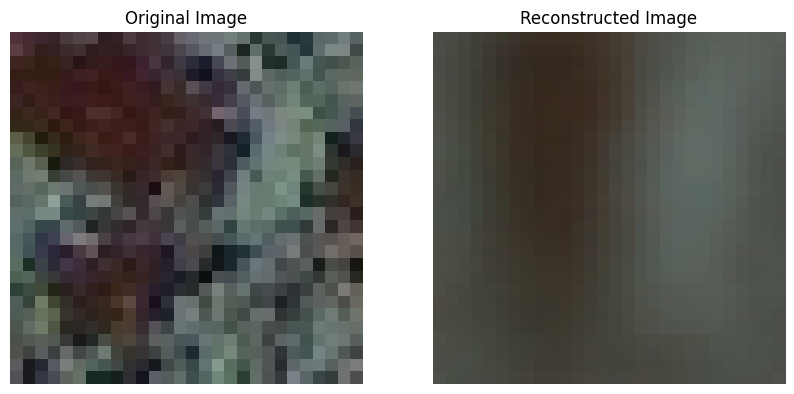

In [90]:
org=np.expand_dims(X_train[6], axis=0)
img = vae(org)

img = img.numpy().squeeze(axis=0)

# Plot the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(X_train[6])
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(img)
plt.axis('off')

plt.show()


In [91]:
class EnhancedClassifierVAE(keras.Model):
    def __init__(self, vae, num_classes):
        super(EnhancedClassifierVAE, self).__init__()

        # Make the encoder layers non-trainable
        self.encoder = vae.encoder
        for layer in self.encoder.layers:
            layer.trainable = False  # Set all encoder layers to non-trainable

        # Additional dense layers for classification
        self.dense_layer_3 = layers.Dense(128, activation='relu')
        self.batch_norm_3 = layers.BatchNormalization()

        self.dense_layer_4 = layers.Dense(64, activation='relu')
        self.batch_norm_4 = layers.BatchNormalization()

        self.classifier_head = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        z_mean = self.encoder(inputs)  # Pass input through non-trainable encoder
        x = self.dense_layer_3(z_mean)
        x = self.batch_norm_3(x)

        x = self.dense_layer_4(x)
        x = self.batch_norm_4(x)

        return self.classifier_head(x)

# Create the enhanced classifier
num_classes = 10
classifierVAE = EnhancedClassifierVAE(vae, num_classes)

# Compile the model
classifierVAE.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Learning rate reduction callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model with the encoder layers frozen
classifierVAE.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.3866 - loss: 1.8159 - val_accuracy: 0.7165 - val_loss: 0.8907 - learning_rate: 1.0000e-04
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.7169 - loss: 0.8236 - val_accuracy: 0.7857 - val_loss: 0.6222 - learning_rate: 1.0000e-04
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - accuracy: 0.7720 - loss: 0.6192 - val_accuracy: 0.8130 - val_loss: 0.5088 - learning_rate: 1.0000e-04
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8083 - loss: 0.5254 - val_accuracy: 0.8397 - val_loss: 0.4438 - learning_rate: 1.0000e-04
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8302 - loss: 0.4530 - val_accuracy: 0.8558 - val_loss: 0.4030 - learning_rate: 1.0000e-04
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.8477 - loss: 0.4094 - val_accuracy: 0.8810 - val_loss: 0.3648 - learning_rate: 1.0000e-04
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


'marble'

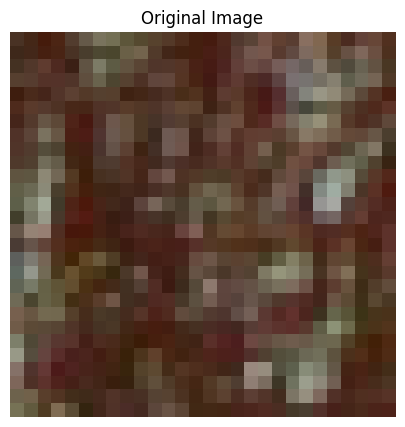

In [103]:
image_path = '/content/geological_similarity/marble/00GNB.jpg'  # Change to your image path
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.figure(figsize=(10, 5))
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

img = img.astype('float32') / 255.0
img_input = np.expand_dims(img, axis=0)

predicted_img = classifierVAE.predict(img_input)

predicted_classes = np.argmax(predicted_img, axis=1)  # Get the index of the highest probability class
labels[predicted_classes[0]]

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class AE(keras.Model):
    def __init__(self, original_dim, latent_dim=8):  # Use the same latent_dim
        super(AE, self).__init__()
        self.original_dim = original_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(28, 28, 3)),
            layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),  # Reduced neurons
            layers.BatchNormalization(),
            layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),  # Reduced neurons
            layers.BatchNormalization(),
            layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),  # Reduced neurons
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(32, activation='leaky_relu'),  # Reduced neurons in dense layer
            layers.Dense(latent_dim)  # Latent space of size 8
        ])

        # Decoder
        self.decoder = keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),  # Latent input is 8-dimensional
            layers.Dense(7 * 7 * 128, activation='leaky_relu'),  # Reduced decoder size
            layers.Reshape((7, 7, 128)),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')  # Output to 3 channels (RGB)
        ])

    def call(self, inputs):
        latent = self.encoder(inputs)  # Direct encoding to latent space
        reconstructed = self.decoder(latent)  # Reconstruct from latent space

        # Calculate reconstruction loss
        reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()
        reconstruction_loss = reconstruction_loss_fn(tf.reshape(inputs, [-1]), tf.reshape(reconstructed, [-1]))
        reconstruction_loss *= self.original_dim[0] * self.original_dim[1]  # Scale loss

        total_loss = tf.reduce_mean(reconstruction_loss)
        self.add_loss(total_loss)
        return reconstructed

# Create the Autoencoder model with reduced neurons and latent space of size 8
ae = AE(original_dim=(28, 28, 3), latent_dim=8)
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
ae.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (None, 8)                   │         159,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 28, 28, 3)           │         149,955 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 309,931 (1.18 MB)

 Trainable params: 309,291 (1.18 MB)

 Non-trainable params: 640 (2.50 KB)

In [34]:

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_generator = datagen.flow(X_train, X_train, batch_size=32)


ae.fit(X_train,X_train, batch_size=32, epochs=50)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 18.3104
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.1849
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.9705
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.2678
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.1112
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.1042
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.9983
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.0043
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.0065
Epoch 10/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.9596
Epoch 11/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.9640
Epoch 12/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.9396
Epoch 13/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.9266
Epoch 14/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.9905
Epoch 15/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - 

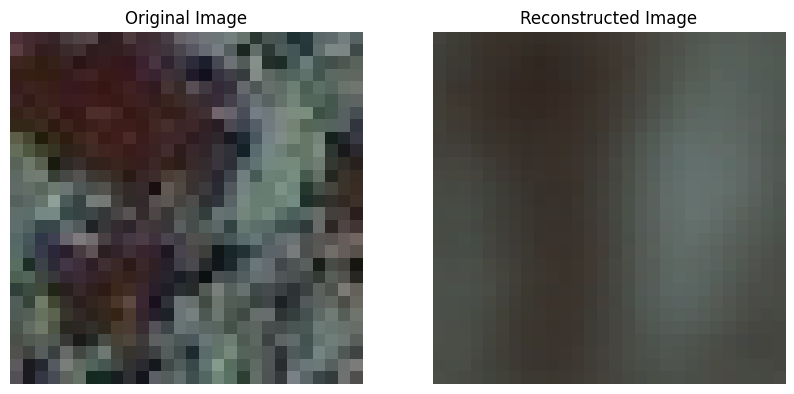

In [106]:
org=np.expand_dims(X_train[6], axis=0)
img = ae(org)

img = img.numpy().squeeze(axis=0)

# Plot the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(X_train[6])
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(img)
plt.axis('off')

plt.show()


In [36]:
class EnhancedClassifierAE(keras.Model):
    def __init__(self, ae, num_classes):
        super(EnhancedClassifierAE, self).__init__()

        # Make the encoder layers non-trainable
        self.encoder = ae.encoder
        for layer in self.encoder.layers:
            layer.trainable = False  # Set all encoder layers to non-trainable

        # Additional dense layers for classification
        self.dense_layer_3 = layers.Dense(128, activation='relu')
        self.batch_norm_3 = layers.BatchNormalization()

        self.dense_layer_4 = layers.Dense(64, activation='relu')
        self.batch_norm_4 = layers.BatchNormalization()

        self.classifier_head = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        z_mean = self.encoder(inputs)  # Pass input through non-trainable encoder
        x = self.dense_layer_3(z_mean)
        x = self.batch_norm_3(x)

        x = self.dense_layer_4(x)
        x = self.batch_norm_4(x)

        return self.classifier_head(x)

# Create the enhanced classifier
num_classes = 10
classifierAE = EnhancedClassifierAE(ae, num_classes)

# Compile the model
classifierAE.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Learning rate reduction callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model with the encoder layers frozen
classifierAE.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4353 - loss: 1.5594 - val_accuracy: 0.7803 - val_loss: 0.7293 - learning_rate: 1.0000e-04
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.8052 - loss: 0.6643 - val_accuracy: 0.8688 - val_loss: 0.4636 - learning_rate: 1.0000e-04
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8675 - loss: 0.4525 - val_accuracy: 0.8955 - val_loss: 0.3552 - learning_rate: 1.0000e-04
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.8870 - loss: 0.3610 - val_accuracy: 0.9015 - val_loss: 0.3103 - learning_rate: 1.0000e-04
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8963 - loss: 0.3198 - val_accuracy: 0.9092 - val_loss: 0.2779 - learning_rate: 1.0000e-04
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9012 - loss: 0.2912 - val_accuracy: 0.9147 - val_loss: 0.2600 - learning_rate: 1.0000e-04
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'marble'

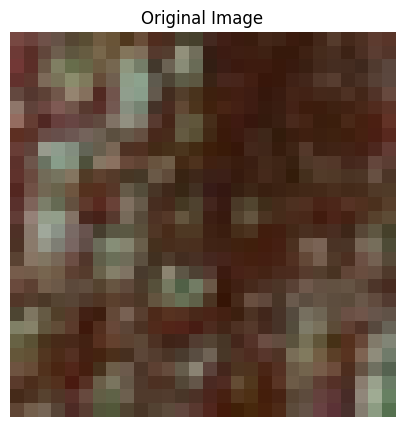

In [104]:
image_path = '/content/geological_similarity/marble/014VO.jpg'  # Change to your image path
img = cv2.imread(image_path)
# rgb_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
# img_resized = cv2.resize(img, (256, 256))  # Resize to match the input shape of the autoencoder
plt.figure(figsize=(10, 5))
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')
img = img.astype('float32') / 255.0

img_input = np.expand_dims(img, axis=0)
predicted_img = classifierAE.predict(img_input)
predicted_classes = np.argmax(predicted_img, axis=1)  # Get the index of the highest probability class
labels[predicted_classes[0]]